<a href="https://colab.research.google.com/github/RuiqingW20/MDanalysis-on-peptides-/blob/main/villin_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...


In [1]:
!conda --version

conda 24.11.2


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install pandas numpy matplotlib
!conda install -c conda-forge openmm
!conda install -c conda-forge mdtraj

In [ ]:
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install biopandas 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null

In [5]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import MDAnalysis as mda
import mdtraj as md
import py3Dmol
from __future__ import print_function
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

In [7]:
workdir='/content/work'
datadir='/content/work/data/'
outdir='/content/work/outdir/'


In [83]:
pdb = datadir+'2F4K.protein.pdb'
trajectory = datadir+'2F4K.protein.s10.dcd'
xray_CA_pdb = datadir + '2f4K.xray.CA.pdb'

In [84]:
trj = md.load(trajectory, top=pdb,stride=10)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [19]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [31]:
residue_num=[]
for res in top.residues:
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)

In [85]:
residue_xray=[]
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
for res in top_xray.residues:
    residue_xray.append(res.resSeq)
residue_xray_CA=np.asarray(residue_xray)
residue_xray_CA

array([42, 43, 44, ..., 74, 75, 76])

In [33]:
trjBB = md.load(trajectory, top=pdb,stride=10)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)

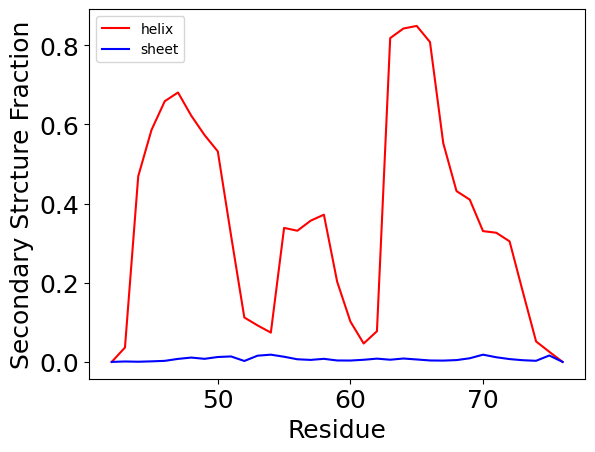

In [34]:
#calculate the helix and b-sheet
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1
 dsspH[dsspH=='E']=0
 dsspH[dsspH=='C']=0
 dsspH[dsspH=='NA']=0
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1)
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE)

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1)
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_xray_CA,Hprop,c='r',label='helix')
plt.plot(residue_xray_CA,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

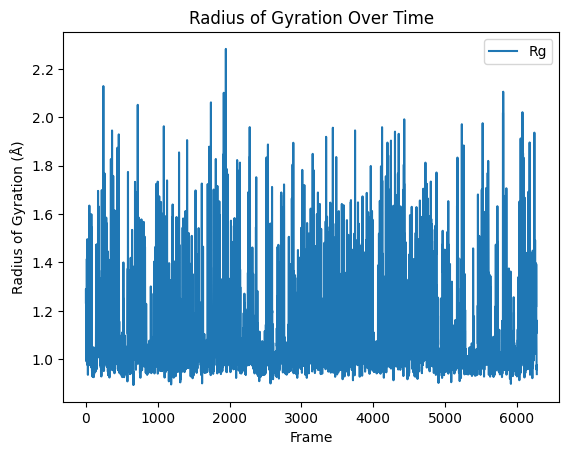

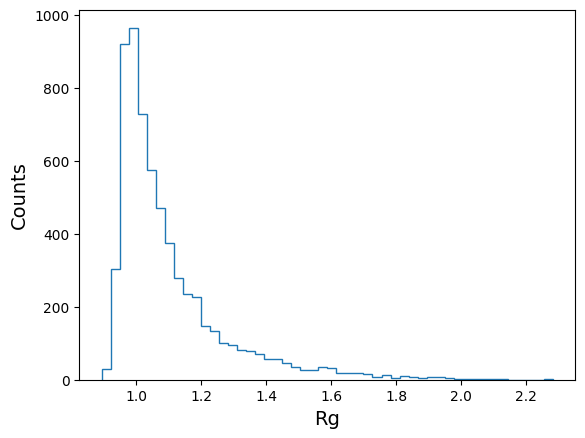

In [35]:
def compute_rg(trj):
    return md.compute_rg(trj)

Rg_values = compute_rg(trj)

# Plot Rg over time
plt.plot(np.arange(trj.n_frames), Rg_values, label="Rg")
plt.xlabel("Frame")
plt.ylabel("Radius of Gyration (Å)")
plt.title("Radius of Gyration Over Time")
plt.legend()
plt.show()

plt.hist(Rg_values,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

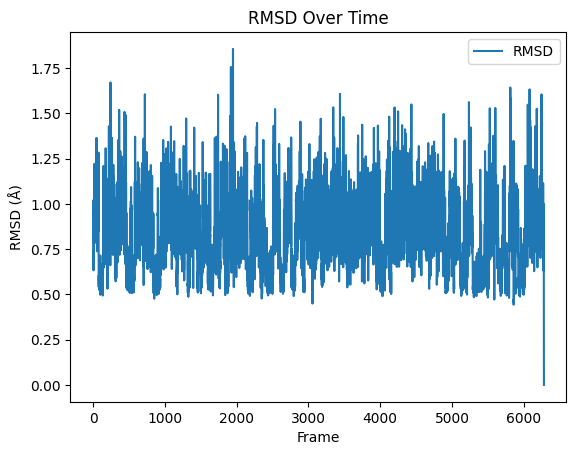

In [40]:
ref = trj[-1]

def compute_rmsd(trj, ref):
    return md.rmsd(trj, ref)

rmsd_values = compute_rmsd(trj, ref)

# Plot RMSD over time
plt.plot(np.arange(trj.n_frames), rmsd_values, label="RMSD")
plt.xlabel("Frame")
plt.ylabel("RMSD (Å)")
plt.title("RMSD Over Time")
plt.legend()
plt.show()



In [ ]:
#calculate ramachamdram plot

In [41]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [42]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [43]:
sequence

' [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]'

In [52]:
def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='viridis')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='viridis')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

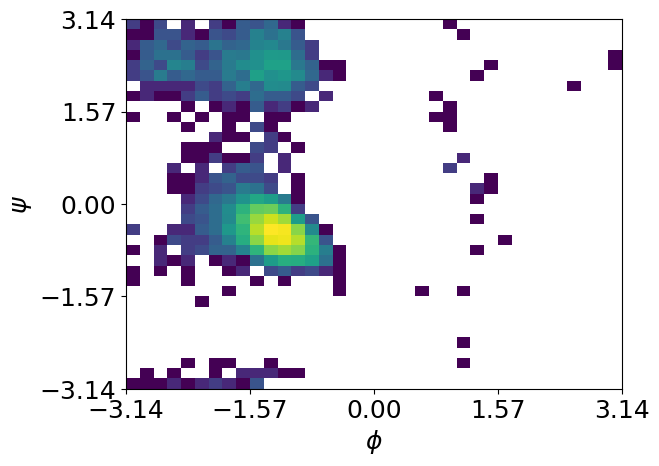

In [49]:
plot_phipsi(45)

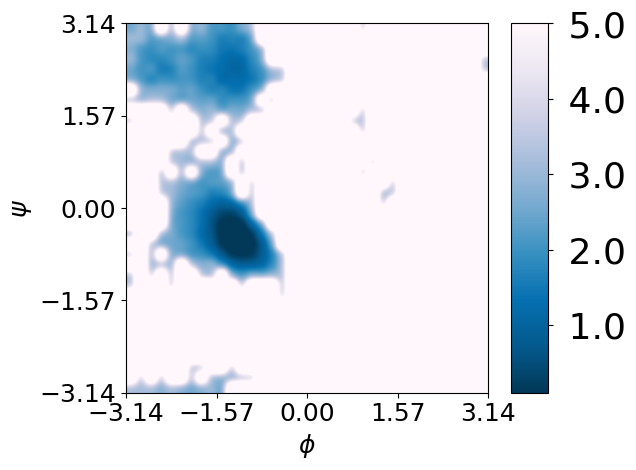

In [55]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='PuBu_r',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(45)

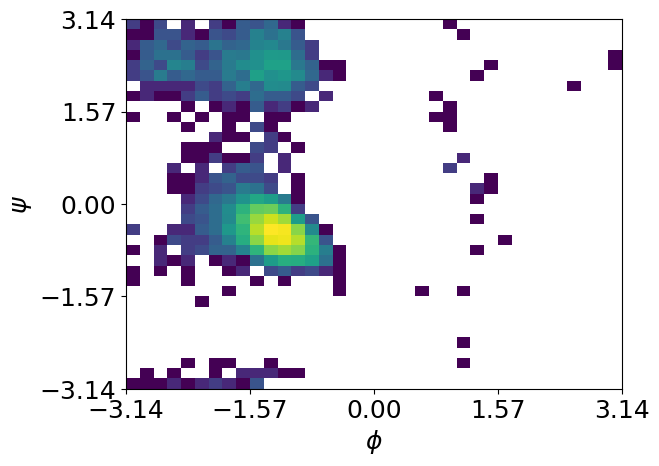

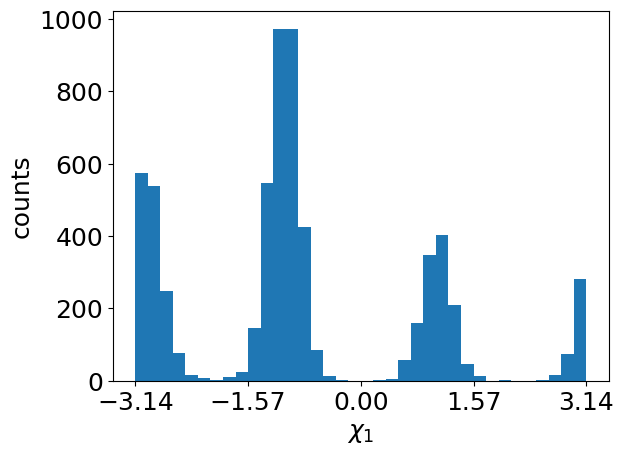

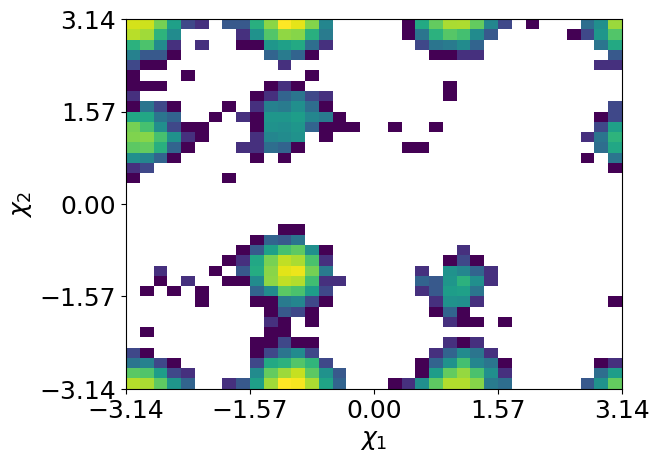

In [56]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [57]:
#Contact Map
contact_maps = []
contact_distances = []
for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [58]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels
n=2
for i in range (0,len(sequence)):
  if (i % n !=0):
   sequence[i]=''

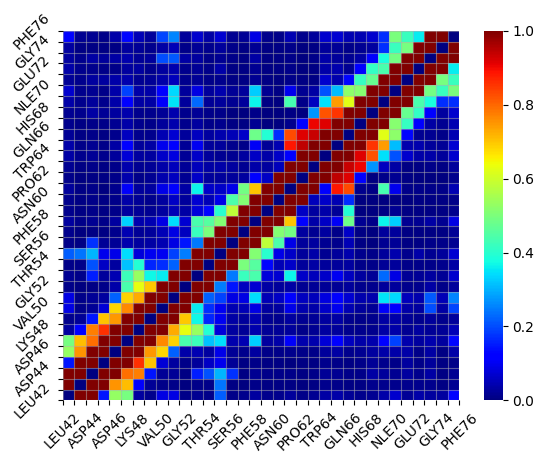

In [59]:
ax = sb.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

make contact

In [86]:
num_frames = xray_CA.n_frames

In [73]:
native_distance_matrix1D=[]
native_distance_matrix1D = [
   contact_distances[i + 7] for i in range(27)
   ]
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [90]:
native_distance_matrix1D

27

In [76]:
contact_distances_per_frame = []
for frame in range(num_frames):
    # Here, we would calculate the contact distances for the current frame.

    frame_contact_distances = contact_distances

    # Extract contact distances where residues are separated by 7
    native_distance_matrix1D = [
        frame_contact_distances[i, i + 7] for i in range(num_residues - 7)
    ]

    # Convert to Angstroms and store the distances for the current frame
    contact_distances_per_frame.append(np.array(native_distance_matrix1D) * 10)

# Convert to a 2D NumPy array: rows are frames, columns are contact distances
contact_distances_per_frame = np.array(contact_distances_per_frame)

print(contact_distances_per_frame.shape)

calculate Hbond among protein

In [91]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [92]:
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)